## Gamma-ray energy deposition

In [1]:
import numpy as np
import astropy.units as u

from tardis.energy_input.base import GammaRay, spawn_gamma_ray, main_gamma_ray_loop
from tardis.energy_input.calculate_opacity import compton_opacity_calculation, photoabsorption_opacity_calculation, pair_creation_opacity_calculation, kappa_calculation
from tardis.energy_input.gamma_ray_grid import distance_trace, move_gamma_ray, mass_distribution
from tardis.energy_input.gamma_ray_interactions import scatter_type

Euler-Rodrigues rotation matrix for Compton Scattering rotation

def euler_rodrigues(theta, direction):
    a = np.cos(theta / 2)
    b = direction.x * np.sin(theta / 2)
    c = direction.y * np.sin(theta / 2)
    d = direction.z * np.sin(theta / 2)
    
    er11 = a ** 2. + b ** 2. - c ** 2. - d ** 2.
    er12 = 2. * (b * c - a * d)
    er13 = 2. * (b * d + a * d)
    
    er21 = 2. * (b * c + a * d)
    er22 = a ** 2. + c ** 2. - b ** 2. - d ** 2.
    er23 = 2. * (c * d - a * b)
    
    er31 = 2. * (b * d - a * c)
    er32 = 2. * (c * d + a * b)
    er33 = a ** 2. + d ** 2. - b ** 2. - c ** 2.
    
    return np.array([[er11, er12, er13],
                     [er21, er22, er23],
                     [er31, er32, er33]])

Quadratic solver to measure the distance to the nearest shell boundary

def quadratic(b, c):
    delta = b ** 2 - 4.0 * c
    if delta > 0:
        delta = np.sqrt(delta)
        delta = delta * np.sign(b)
        q = -0.5 * (b + delta)
        x1 = q
        x2 = c / q
    elif delta < 0:
        x1 = -np.inf
        x2 = -np.inf
    else:
        x1 = -2.0 * c / b
        x2 = -np.inf
    return x1, x2

Gamma rays are spawned from a defined volume given by a density profile f(r).

They are propagated through ejecta until interaction with an electron.

Their energy loss due to interactions is deposited into the ejecta.

Be et al 2006 energy levels should be sampled. For now, the code simply has a random energy from 0 to 100,000 eV

#Constant to begin with
def sample_energy_distribution():
    return np.random.random() * 100.0e3

Basic spherical coordinate vector with properties to convert to Cartesian coordinates

#Probably need an ejecta class to contain the ejecta model

class SphericalVector(object):
    """
    Direction object to hold spherical polar and Cartesian directions
    """
    def __init__(self, r, mu, phi=0.):
        self.r = r
        self.mu = mu
        self.phi = phi
        
    @property
    def theta(self):
        return np.arccos(self.mu)
        
    @property
    def x(self):
        return self.r * np.sin(np.arccos(self.mu)) * np.cos(self.phi)
    
    @property
    def y(self):
        return self.r * np.sin(np.arccos(self.mu)) * np.sin(self.phi)
    
    @property
    def z(self):
        return self.r * self.mu

Gamma rays have a location, direction, energy, status and shell.

class GammaRay(object):
    """
    Gamma ray object with location, direction and energy
    """
    def __init__(self, location, direction, energy, status, shell):
        self.location = location
        self.direction = direction
        self.energy = energy
        self.status = status
        self.shell = shell

Need to sample density from a distribution. In this case, a simple exponential.

#Need to use homologous expansion to get real radii
def density_profile(t, rho_0, t_0, r, max_r):
    return rho_0 * (t / t_0) ** -3. * np.exp(-r / max_r)

Calculate the total ejecta mass from the center to radius r' through numerical integration of the density profile in spherical coordinates.  To do this, we sum over very small spherical shells i of constant density $\rho_i$ from the center of the ejecta to the desired radius $r_i$.

$M_i = 4/3 \pi \rho_i (r_i^3 - r_{i-1}^3)$

Normalized to the maximum mass.

To  get  the  decay  position  spherical coordinates have to be sampled as well

def mass_distribution(radial_grid_size, inner_radius, outer_radius, t, rho_0, t_0):
    
    size = outer_radius - inner_radius
    dr = size / radial_grid_size
    
    r = inner_radius
    
    mass = np.zeros(radial_grid_size)
    radii = np.zeros(radial_grid_size)
    density = np.zeros(radial_grid_size)
    
    i = 0
    while i < radial_grid_size:
        radii[i] = r
        density[i] = density_profile(t, rho_0, t_0, radii[i], outer_radius)
        if i == 0:
            mass[i] = 4. / 3. * np.pi * density_profile(t, rho_0, t_0, radii[i], outer_radius) * radii[i] ** 3.   
        else:
            mass[i] = 4. / 3. * np.pi * density_profile(t, rho_0, t_0, radii[i], outer_radius) * \
            (radii[i] ** 3. - radii[i - 1] ** 3.)  

        i += 1
        r += dr
        
    mass[radial_grid_size - 1] = (4. / 3. * np.pi * density_profile(t, rho_0, t_0, radii[radial_grid_size - 1], outer_radius) * \
                              (radii[radial_grid_size - 1] ** 3. - radii[radial_grid_size - 2] ** 3.))
    
    return radii, mass / np.max(mass), density

Pick a random number z. The chosen radius r is now the radius r′ at which the cumulative distribution has the mass
$M/M_{tot} = z$

def density_sampler(radii, mass_ratio):   
    z = np.random.random()   
    index = np.searchsorted(mass_ratio, z)
    return radii[index], index

Basic random direction samplers. Currently working in 2D so $\phi = 0$

#Both should be fine
def phi_sampler():
    #return np.arccos(1. - 2. *  np.random.random())
    return 0.

def theta_sampler():
    return 2. * np.pi * np.random.random()

def mu_sampler():
    return 2.0 * np.random.random() - 1.0

Spawns gamma-rays with a randomly sampled direction, energy, and location.

Note for positrons, spawn a second photon in the opposite direction. Both have 511 KeV.

#Very incomplete
def spawn_gamma_ray(gamma_ray, radii, mass_ratio, positron=False):  
    direction_mu = mu_sampler()
    direction_phi = phi_sampler()
    
    if positron:
        gamma_ray.energy = 511.0e3
    else:
        gamma_ray.energy = sample_energy_distribution()
        
    initial_radius, shell = density_sampler(radii, mass_ratio)
    
    if shell < len(radii) - 1:
        initial_radius += np.random.random() * (radii[shell + 1] - radii[shell])
        
    
    gamma_ray.shell = shell
        
    gamma_ray.direction = SphericalVector(1., direction_mu, direction_phi)
    
    location_mu = mu_sampler()
    location_phi = phi_sampler()
    gamma_ray.location = SphericalVector(initial_radius, location_mu, location_phi)
        
    return gamma_ray

1D distance to boundary from TARDIS

def calculate_distance_boundary(r, mu, r_inner, r_outer):
    delta_shell = 0
    if (mu > 0.0):
        print("direction outward")
        distance = np.sqrt(r_outer**2 + ((mu**2 - 1.0) * r**2)) - (r * mu)
        delta_shell = 1
    else:
        print("going inward")
        check = r_inner**2 + (r**2 * (mu**2 - 1.0))

        if (check >= 0.0):
            print("hit inner boundary ")
            distance = -r * mu - np.sqrt(check)
            delta_shell = -1
        else:
            print("miss inner boundary")
            distance = np.sqrt(r_outer**2 + ((mu**2 - 1.0) * r**2)) - (r * mu)
            delta_shell = 1
    
    return distance, delta_shell

Corrected distance to the boundary including the 3D direction vectors.

def calculate_distance_radial(gamma_ray, r_inner, r_outer):
    
    direction_square = gamma_ray.direction.x ** 2. + gamma_ray.direction.y ** 2. + gamma_ray.direction.z ** 2.
    position_square = gamma_ray.location.x ** 2. + gamma_ray.location.y ** 2. + gamma_ray.location.z ** 2.
    position_direction = gamma_ray.direction.x * gamma_ray.location.x + \
                        gamma_ray.direction.y * gamma_ray.location.y + \
                        gamma_ray.direction.z * gamma_ray.location.z
    
    on_inner_wall = False
    on_outer_wall = False
    
    distances = []
    
    if np.abs(gamma_ray.location.r - r_inner) < 5:
        on_inner_wall = True
        
    if np.abs(gamma_ray.location.r - r_outer) < 5:
        on_outer_wall = True

    quadratic_b = 2. * position_direction
    quadratic_c = position_square
    
    quad_c_inner = quadratic_c - r_inner ** 2
    distance_1, distance_2 = quadratic(quadratic_b, quad_c_inner)
    
    if on_inner_wall:
        if np.abs(distance_1) < np.abs(distance_2):
            distances.append(distance_2)
        else:
            distances.append(distance_1)
    else:
        distances.append(distance_1)
        distances.append(distance_2)
    
    quad_c_outer = quadratic_c - r_outer ** 2
    distance_3, distance_4 = quadratic(quadratic_b, quad_c_outer)
    
    if on_outer_wall:
        if np.abs(distance_3) < np.abs(distance_4):
            distances.append(distance_4)
        else:
            distances.append(distance_3)
    else:
        distances.append(distance_3)
        distances.append(distance_4)
        
    distances = [item for item in distances if item >= 0]
    if len(distances) > 0:
        distance = min(distances, key=abs)
    else:
        distance = 0.0

    return distance

Measure the distance to the next interaction, and determine if it's less than the distance to the next shell boundary.

If so, we've hit an electron!

def distance_trace(gamma_ray, radii, total_opacity, distance_moved):
    
    if packet.shell < len(radii) - 1:
        distance_boundary = calculate_distance_radial(gamma_ray, radii[packet.shell], radii[packet.shell + 1])
    else:
        distance_boundary = 0.0
    
    z = np.random.random()
    tau = -np.log(z)
    
    distance_interaction = tau / total_opacity - distance_moved
    
    if distance_interaction < distance_boundary:
        return distance_interaction, distance_boundary, True
    else:
        return distance_interaction, distance_boundary, False

Randomly choose an interaction type, weighted by their opacity.

#Event handler, basically
def scatter_type(gamma_ray, compton_opacity, photoabsorption_opacity, total_opacity):
    
    z = np.random.random()
    
    ejecta_energy_gain = 0.0
    pair_created = False
    
    if z <= compton_opacity / total_opacity:
        ejecta_energy_gain = compton_scatter(gamma_ray)
    elif z <= (compton_opacity + photoabsorption_opacity) / total_opacity:
        ejecta_energy_gain = photoabsorption(gamma_ray)
    else:
        pair_creation(gamma_ray)
        pair_created = True
        
    return ejecta_energy_gain, pair_created

### Compton scattering and opacity calculations

Energy $E_s = E / (1 + \kappa (1 - \cos\theta_C))$

Integrate eq 4.15 Andreas MSc thesis to get $\theta_C$

Sample $\phi_C$ from 0 to $2\pi$ using phi_sampler

Opacity $\chi_C = n_e^{tot} \sigma_{KN}$

def kappa_calculation(energy):
    k = energy / 511.0e3
    return k

def klein_nishina(energy, theta_C):
    r_e = 2.8179403227e-15
    kappa = kappa_calculation(energy) 
    return r_e / 2 * \
            (1. + kappa * (1. - np.cos(theta_C))) ** -2. * \
            (1. + np.cos(theta_C) ** 2. + \
            (kappa ** 2. * (1. - np.cos(theta_C)) ** 2.) / (1. + kappa * (1. - np.cos(theta_C))))

def compton_scatter(gamma_ray):
    #print("== Compton scatter ==")   
    sample_resolution = 100
    dtheta = np.pi / sample_resolution
    
    theta_distribution = np.zeros(sample_resolution)
    theta_angles = np.ones(sample_resolution) * np.pi
    
    theta = 0.
    for i in range(sample_resolution - 1):
        theta_distribution[i + 1] = \
                theta_distribution[i] + klein_nishina(gamma_ray.energy, theta)
        theta_angles[i] = theta
        theta += dtheta
    
    theta_distribution /= np.max(theta_distribution)
    
    z = np.random.random()
    
    #sample new random theta direction
    random_vector = SphericalVector(1., mu_sampler(), phi_sampler())
    
    perpendicular_vector_x = gamma_ray.direction.y * random_vector.z - gamma_ray.direction.z * random_vector.y
    perpendicular_vector_y = gamma_ray.direction.z * random_vector.x - gamma_ray.direction.x * random_vector.z
    perpendicular_vector_z = gamma_ray.direction.x * random_vector.y - gamma_ray.direction.y * random_vector.x
    
    perpendicular_vector = np.array([perpendicular_vector_x, perpendicular_vector_y, perpendicular_vector_z])
    
    #get Compton scattering angle
    compton_angle = theta_angles[np.searchsorted(theta_distribution, z)]
    
    #rotate to match
    rotation_matrix = euler_rodrigues(compton_angle, gamma_ray.direction)
    
    #rotate to match
    resulting_direction = np.dot(rotation_matrix, perpendicular_vector)
    
    gamma_ray.direction.mu = resulting_direction[2]
    
    #generate new random phi direction
    gamma_ray.direction.phi = phi_sampler()
    
    #Energy calculations
    new_energy = gamma_ray.energy / (1. + kappa_calculation(gamma_ray.energy) * (1. - gamma_ray.direction.mu))  
    lost_energy = gamma_ray.energy - new_energy   
    gamma_ray.energy = new_energy
    
    return lost_energy
    

def compton_opacity_calculation(electron_number_density, energy):
    
    kappa = kappa_calculation(energy)
    
    sigma_T = 6.65e-25

    a = (1. + 2. * kappa)
    
    sigma_KN = 3. / 4. * sigma_T * \
            ((1. + kappa) / kappa ** 3. * ((2. * kappa * (1. + kappa)) / a - np.log(a)) + \
             1. / (2. * kappa) * np.log(a) - (1. + 3 * kappa) / a ** 2.)
    
    return electron_number_density * sigma_KN

### Photoabsorption opacity

Gamma-ray energy transferred to electron

Opacity eq 4.22

m_Si = 28.085 * u.M_p
m_Fe = 55.845 * u.M_p

#Need to keep track of energy in the ejecta
def photoabsorption(gamma_ray):
    #print("== Photoabsorption ==")
    
    gamma_ray.status = 'Absorbed'
    return gamma_ray.energy

    

def photoabsorption_opacity_calculation(energy, ejecta_density, iron_group_fraction):
    
    Si_opacity = 1.16e-24 * (energy / 100.0e3) ** -3.13 * ejecta_density / m_Si.value * (1. - iron_group_fraction)
    
    Fe_opacity = 25.7e-24 * (energy / 100.0e3) ** -3.0 * ejecta_density / m_Fe.value * (1. - iron_group_fraction)
    
    return Si_opacity + Fe_opacity

### Pair creation opacity and scattering

Incoming photon destroyed, 2 x 511 KeV photons created, remaining energy deposited

def pair_creation(gamma_ray):
    print("== Pair creation ==")
    direction_mu = mu_sampler()
    direction_phi = phi_sampler()
    
    gamma_ray.energy = 511.0e3
    gamma_ray.direction = SphericalVector(1.0, direction_mu, direction_phi)
    

def pair_creation_opacity_calculation(energy, ejecta_density, iron_group_fraction):
    
    Z_Si = 14
    Z_Fe = 26

    Si_proton_ratio = Z_Si ** 2. / m_Si.value
    Fe_proton_ratio = Z_Fe ** 2. / m_Fe.value
    
    multiplier = ejecta_density * (Si_proton_ratio * (1. - iron_group_fraction) + Fe_proton_ratio * iron_group_fraction)
    
    if energy > 1.022e6 and energy < 1.5e6:
        opacity = multiplier * 1.0063 * (energy / 100.0e6 - 1.022) * 1.0e-27
    else:
        opacity = multiplier * (0.0481 + 0.301 * (energy / 100.0e6 - 1.5)) * 1.0e-27
        
    if opacity < 0.:
        opacity = 0.
        
    return opacity

Moves the gamma-ray in the direction of its travel by a distance

def move_gamma_ray(gamma_ray, distance):
    #print("move_gamma_ray")
    r = gamma_ray.location.r
    
    #print("new r:", np.sqrt(r ** 2. + distance ** 2. +
    #                     2.0 * r * distance * gamma_ray.location.mu) / outer_rad)
    
    x_old = gamma_ray.location.x
    y_old = gamma_ray.location.y
    z_old = gamma_ray.location.z
    
    x_new = x_old + distance * gamma_ray.direction.x
    y_new = y_old + distance * gamma_ray.direction.y
    z_new = z_old + distance * gamma_ray.direction.z
    
    gamma_ray.location.r = np.sqrt(x_new ** 2. + y_new ** 2. + z_new ** 2.)
    gamma_ray.location.mu = z_new / gamma_ray.location.r
    
    return gamma_ray
    

### Main loop

Generates a simple 1D ejecta and a list of gamma-ray objects.

Runs packets of gamma-rays through the ejecta. Handles interactions by calling the appropriate function. 

Appends deposited energy and output energy to 2 different lists. Currently no binning.

In [4]:
import matplotlib.pyplot as plt
from tardis.model import Radial1DModel
from tardis.io.config_reader import Configuration

num_packets = 1e5
num_packets = int(num_packets)

np.random.seed(1)

config = Configuration.from_yaml("../../tardis/io/tests/data/tardis_configv1_verysimple.yml")

model = Radial1DModel.from_config(config)

ejecta_energy, ejecta_energy_r, escape_energy, radii = main_gamma_ray_loop(num_packets, model, path="/home/afullard/Downloads/tardisnuclear/decay_radiation.h5")


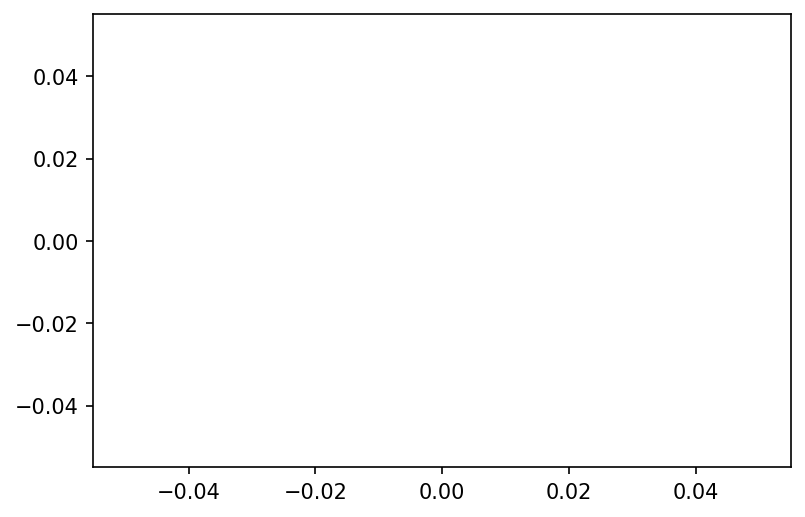

In [5]:
fig = plt.figure(dpi=150, facecolor='w')
ax = fig.add_subplot(111)
ax.plot(np.array(ejecta_energy_r), np.array(ejecta_energy), '.')

(array([3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.800e+01, 0.000e+00, 1.700e+01, 6.750e+03, 0.000e+00, 7.000e+00,
        8.100e+01, 0.000e+00, 0.000e+00, 9.130e+02, 0.000e+00, 2.000e+00,
        9.000e+00, 0.000e+00, 1.600e+02, 4.402e+03, 0.000e+00, 1.000e+00,
        9.000e+00, 0.000e+00, 3.240e+02, 0.000e+00, 0.000e+00, 9.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.057e+03,
        0.000e+00, 0.000e+00, 0.000e+00, 4.200e+01, 5.700e+01, 0.000e+00,
        0.000e+00, 0.000e+00, 2.280e+02, 0.000e+00, 5.410e+02, 0.000e+00,
        0.000e+00, 3.100e+01, 0.000e+00, 0.000e+00, 1.000e+01, 0.000e+00,
        4.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.142e+03, 0.000e+00, 1.000e+00, 0.000e+00, 6.600e+01,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

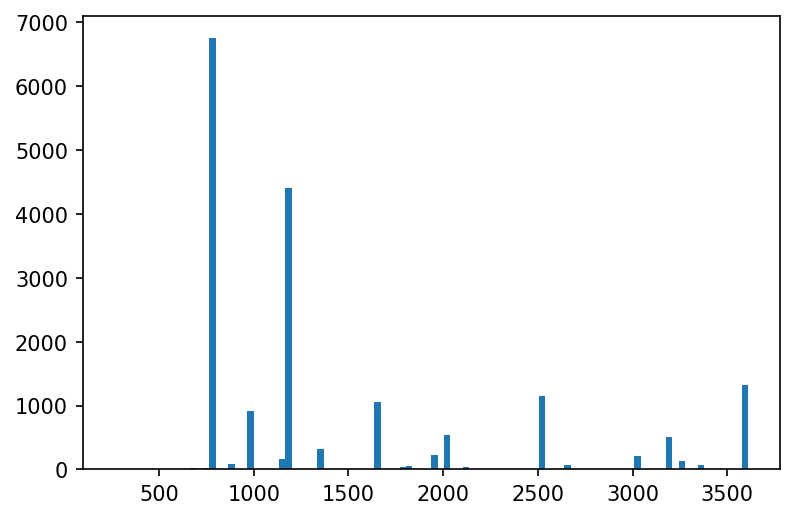

In [6]:
fig = plt.figure(dpi=150, facecolor='w')
ax = fig.add_subplot(111)
ax.hist(np.array(escape_energy), bins=100)